
# <center>TEMPORAL SERIES ANALYSIS:RNN MODELS** </center>



## <span style="color:red"> Outline </span>
1. **Forecasting: Sequences and Time series**
2. **Forecasting from RNN models**
3. **Forecasting to predict stock market index**



In [38]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [39]:
#@title Load libraries { display-mode: "form" }
#@markdown Here is important to change to GPU

import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
print(tf.__version__)

2.17.1


#**1. Forecasting: Sequences and Time series**

<img src="https://github.com/wDavid98/IA-docs/blob/main/data/RNN/applications.png?raw=true" style="width:900;height:450px;">

Time series is everywere from signals thar represent monitoring industrial processes to series that track corporate business metrics. Other applications include economic, sales and Weather forescasting. So, time series are **ordered sequences**.


- In machine learning, a fundamental problem is **forecasting** over temporal series.

**1.1 Forecasting: preparing data**

To prepare data to acess over such models, we need to do a special configuration in data. In this case, training, validation and test sets are defined as follows:

<img src="https://github.com/wDavid98/IA-docs/blob/main/data/RNN/setsplit.png?raw=true" width="600" height="400">

**Remember**

In this regression problems, we define error as the different between forecast $f_t$ and actual value $y_t$, as: $error = f_t - y_t$. Typical metrics to measure this errors are:

- **the mean square error** ($mse = \frac{1}{N}\sum_{t=1}^{N}(f_t - y_t)^2$)
- **the  mean absolute error** ($mae = \frac{1}{N}\sum_{t=1}^{N}|f_t - y_t|$)


Now, we will try the proble to predict the temperature according to historical data in metereology.

**GO to the action!**








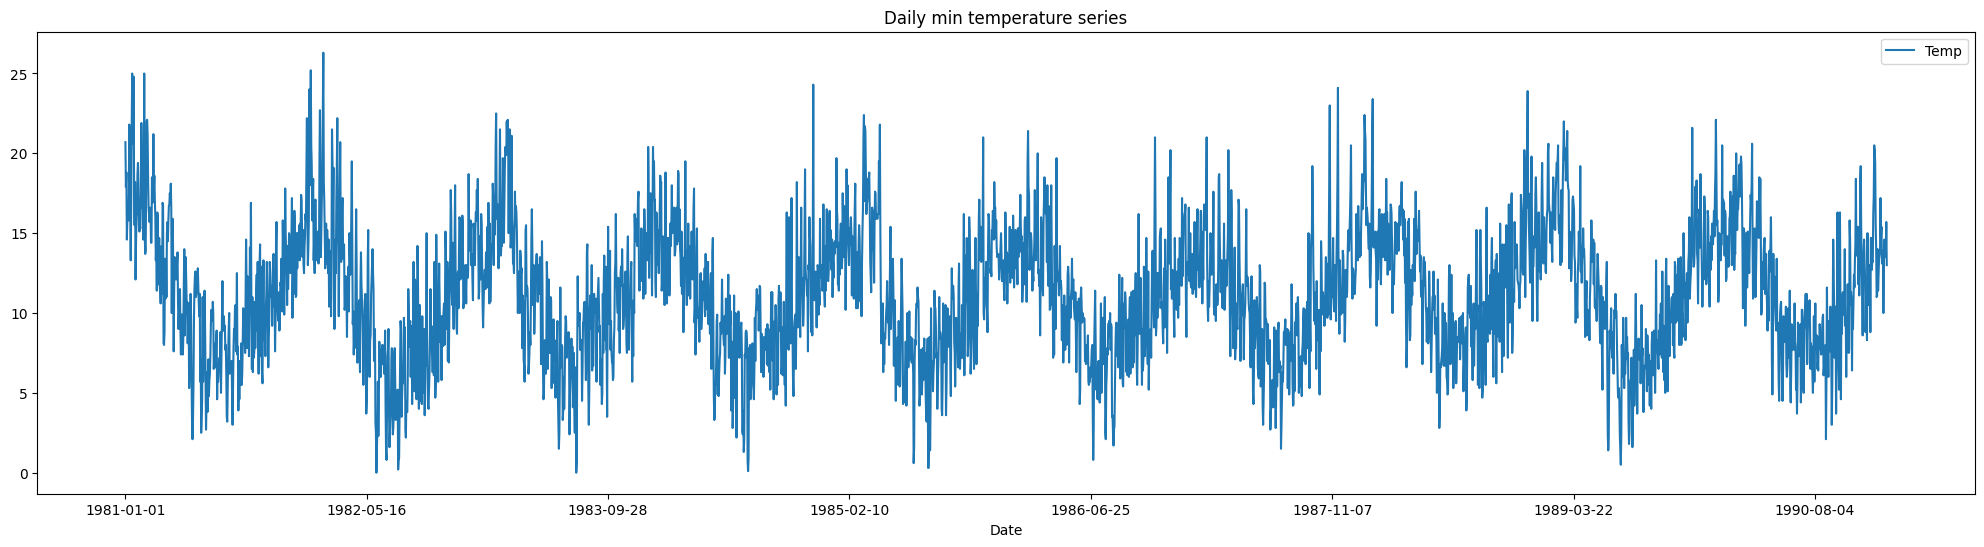

In [40]:
#@title **code:** load and visualize the data
data_tem = pd.read_csv("/content/drive/MyDrive/Academia40/Notebooks/data/dailyMin_temperatures.csv")
ax = data_tem.plot(x='Date',title='Daily min temperature series', figsize=(25, 6));
#@title Plot train, validation and test series { display-mode: "form" }data_tem.head()

**CHALLENGE**

Implement a function that split serie in training, validation and test, according to some input sizes.

- Split both: series `series_split` and corresponding time `time_split`
- Return  a list with the three respective sub-lists

In [41]:
#@title split series
def split_series(time, serie, train_rate=0.5, test_rate=0.25, validation_rate=0.25):
    num_examples = len(serie)
    # split series in train, validation and test sets
    series_split = [serie[:int(num_examples*train_rate)],
                    serie[int(num_examples*train_rate):int(num_examples*train_rate)+int(num_examples*validation_rate)],
                    serie[-int(num_examples*test_rate):]]
    # split time for train, validation and test series
    time_split = [time[:int(num_examples*train_rate)],
                  time[int(num_examples*train_rate):int(num_examples*train_rate)+int(num_examples*validation_rate)],
                  time[-int(num_examples*test_rate):]]

    return time_split, series_split

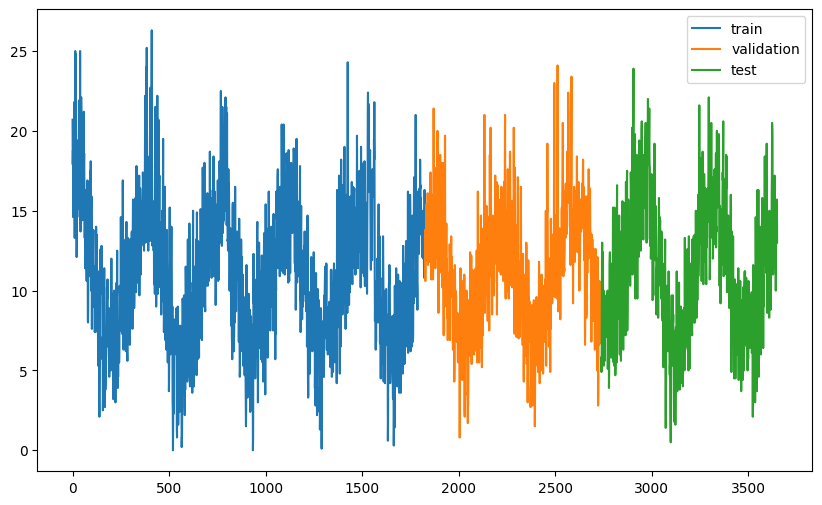

In [42]:
#@title plot the resultant splits

data_tem = pd.read_csv("/content/drive/MyDrive/Academia40/Notebooks/data/dailyMin_temperatures.csv")
series = data_tem.Temp.values
time = data_tem.index.values


time_sets, series_sets = split_series(time, series)
fig = plt.figure(figsize=(10, 6))
plt.plot(time_sets[0], series_sets[0], label='train')
plt.plot(time_sets[1], series_sets[1], label='validation')
plt.plot(time_sets[2], series_sets[2], label='test')
plt.legend()
plt.show()

#**2. Forecasting from RNN models**
 Same forecasting problem can be solved with deep neural networks with main advantage to learn weigths of history serie and also to be adaptable to very non linear changes, commonly in time series of real scenarios.

Firstly we need to arrange dataset for training net, in sense that works as illustrated in next figure:

### **2.1 Built the dataset for Tensorflow and RNN**
<img src="https://github.com/wDavid98/IA-docs/blob/main/data/RNN/sliding_dataset.gif?raw=true" style="width:700;height:350px;">

Tensorflow help with this construction using `from_tensor_slices`. For instance for a serie:

```
[0, 1, 2, 3, 4, 5, 6, 7]
```

Firstly split data and  create the windows shifted 1 position (
`dataset.window()`):

```
[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
```
Then, choose for $t-w$ features for $t$ value:

```
[0, 1, 2, 3][4]
[1, 2, 3, 4][5]
[2, 3, 4, 5][6]
```
 Then shuffle data. See the function as follows:







In [43]:
#@title **code** building the dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position,
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [44]:
#@title **code** create the dataset for RNN

window_size = 30 # number of features in a window
batch_size = 128 # number of samples
shuffle_buffer_size = 1000 # shuffle the first 1000 samples
per_test = 0.3 # percentage of data to test

# Split series into train, validation and test
# load data
data_tem = pd.read_csv("/content/drive/MyDrive/Academia40/Notebooks/data/dailyMin_temperatures.csv")
serie = data_tem.Temp.values
len_n = len(serie)
time = data_tem.index.values
time_sets, series_sets = split_series(time=time, serie=serie, train_rate=0.7, validation_rate=0.20, test_rate=0.10)

dataset = windowed_dataset(series_sets[0], window_size=window_size, batch_size=32, shuffle_buffer=100)

We can visualize the dataset arrangement as follows:

In [45]:
#@title **code** visualize one example in dataset
for i, (x,y) in enumerate(dataset):
  if i == 1:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (temperature days): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

Number of samples in each batch:  32
Number of labels in each batch:  32
Number of features of each sample (temperature days):  30
---------------------
X_1 = 
 [10.   9.8 11.5  8.9  7.4  9.9  9.3  9.9  7.4  8.6 11.9 14.   8.6 10.
 13.5 12.  10.5 10.7  8.1 10.1 10.6  5.3  6.6  8.5 11.2  9.8  5.9  3.2
  2.1  3.4]


Y_1 =  5.4


### **4.2 Built the RNN**

In [46]:
#@title **code** Building  the RNN model

# Define the layers ########################################################
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(shape=(window_size,))
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model = tf.keras.Model(inputs=input_, outputs=y)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ InputTransform (Lambda)              │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ RNN_layer1 (SimpleRNN)               │ (None, 30, 20)              │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ RNN_layer2 (SimpleRNN)               │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ouput_layer (Dense)                  │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
#@title **code** Now we proceed to train the model

# Clear the previous sessions and set the seed
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))
# fit
history = model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 83.8233 - mae: 7.5814 - mse: 83.8233
Epoch 2/100
 6/79 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 17.5089 - mae: 3.2910 - mse: 17.5089

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 15.9330 - mae: 3.1683 - mse: 15.9330
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 10.9061 - mae: 2.5243 - mse: 10.9061
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.8307 - mae: 2.2719 - mse: 8.8307
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.1388 - mae: 2.1932 - mse: 8.1388
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.9526 - mae: 2.1772 - mse: 7.9526
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.7279 - mae: 2.1397 - mse: 7.7279
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.4987 - mae: 2.1090 - mse: 7.4987
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.2643 - mae: 2.0764 - mse: 7.2643
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.3435 - mae: 2.0853 - mse: 7.3435
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.5743 - mae: 2.1306 - mse: 7.5743
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - l

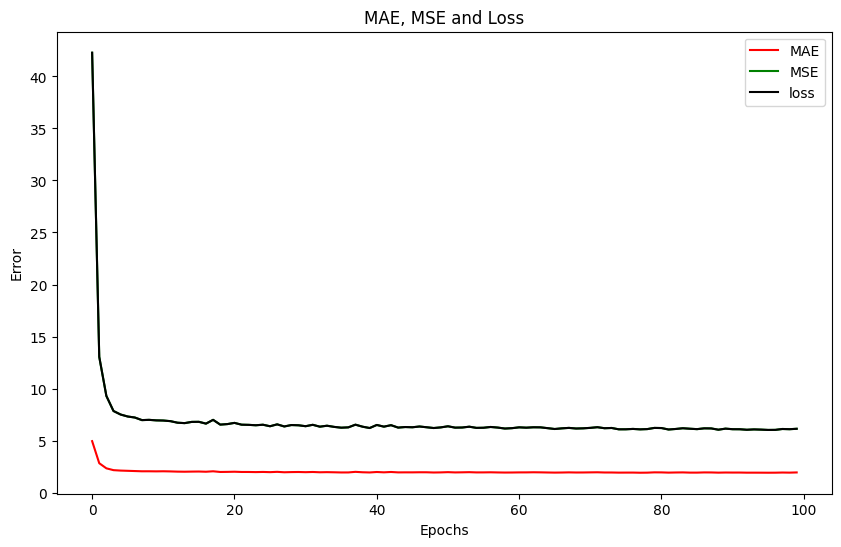

In [48]:
#@title **code** Plot performance on training
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']


epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

**Finally, we can forecasting with RNN model**

In [49]:
#@title **code**  we can run same walk forward over time steps in validation and test

validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

forecast_validation = []
forecast_test = []
for t in range(len_n-1):
    if t >= validation_init and t < test_init:
        # Don't forget to add the extra axis to predict
        forecast_validation.append(model.predict(serie[t-window_size:t][np.newaxis]))
    elif t >= test_init:
        forecast_test.append(model.predict(serie[t-window_size:t][np.newaxis]))

# delete 1 dimensions to plot results
forecast_validation = np.squeeze(np.array(forecast_validation))
forecast_test = np.squeeze(np.array(forecast_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [50]:
#@title **code**: plot_series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

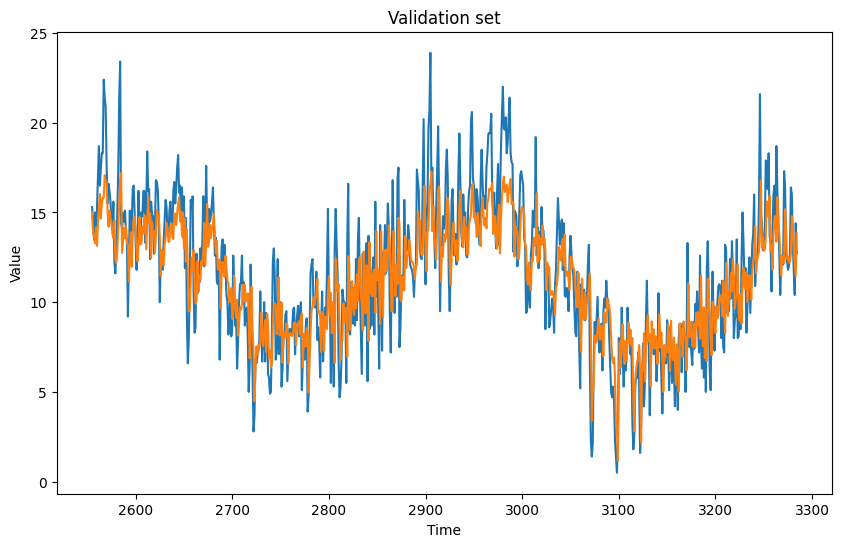

MSE in validation set 5.6136303
MAE in validation set 1.8805745


In [51]:
#@title plot forecast in validation { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Validation set')
plot_series(time_sets[1], series_sets[1])
plot_series(time_sets[1], forecast_validation)
plt.show()
print('MSE in validation set', tf.keras.metrics.MSE(series_sets[1], forecast_validation).numpy())
print('MAE in validation set', tf.keras.metrics.MAE(series_sets[1], forecast_validation).numpy())

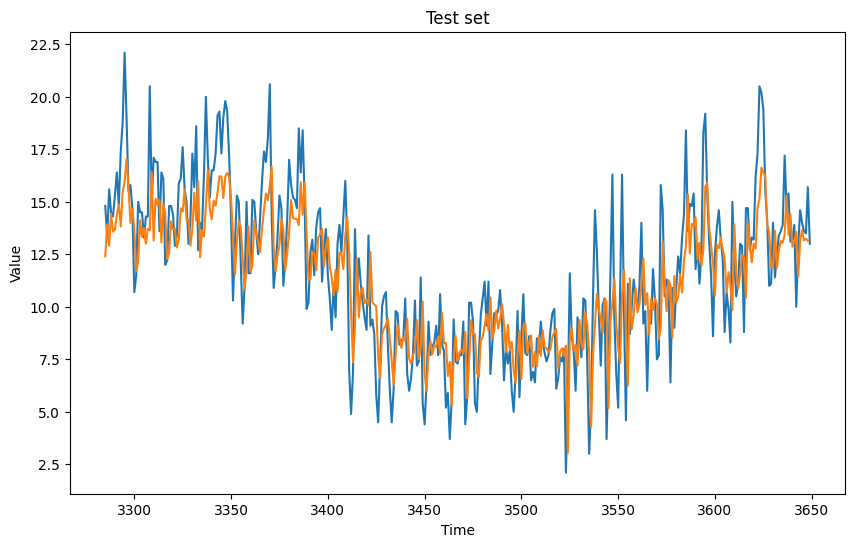

MSE in test set 5.292339
MAE in test set 1.7916833


In [52]:
#@title plot forecast in test { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()

print('MSE in test set', tf.keras.metrics.MSE(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.MAE(series_sets[2][:-1], forecast_test).numpy())

# **3. Forecasting to predict stock market index**

**CHALLENGE**
Forecasting of IBM stock market index. Please load the dataset in data :

```
datasets_8388_11883_IBM_2006-01-01_to_2018-01-01
```
 - Use only one serie (High, for instance) to train and configurate RNN.
 - Use for training 70% and the rest for test

In [53]:
#@title **code** Load data of IBM
data_IBM = pd.read_csv("/content/drive/MyDrive/Academia40/Notebooks/data/datasets_8388_11883_IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data_IBM.shape)
data_IBM.head(5)

(3020, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


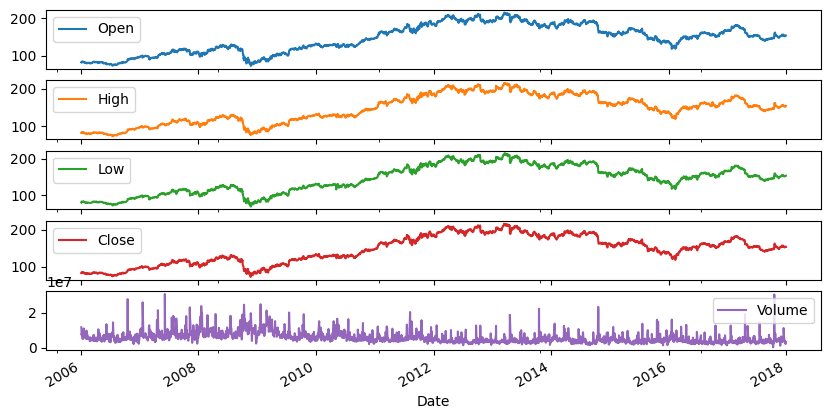

In [54]:
#@title **code** plot data
data_IBM.plot(subplots=True, figsize=(10,5));

In [55]:
#@title select for training all dataes until 2016
#@markdown we only we should to consider **HIGH**

#@markdown for test use 2017 data
set_entrenamiento = data_IBM[:'2016'].iloc[:,1:2]
set_test = data_IBM['2017':].iloc[:,1:2]

print(set_entrenamiento.shape, set_test.shape)

set_entrenamiento.head(3)

(2769, 1) (251, 1)


,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90


In [56]:
#@title we typically should normalize data to obtain a better performance
#@markdown Use MaxMinscaler to scale trainin set betwwen [0-1]
#@markdown Use also standardscaler

#@markdown Reshape to (data,)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#sc = MinMaxScaler(feature_range=(0,1))
sc = StandardScaler()
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
set_test_escalado = sc.transform(set_test)
set_entrenamiento_escalado = set_entrenamiento_escalado.reshape(set_entrenamiento_escalado.shape[0])
set_test_escalado = set_test_escalado.reshape(set_test_escalado.shape[0])

In [57]:
#into a dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position,
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    if (shuffle_buffer is not 0):
      print("shuffle")
      dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size=50
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=100)

shuffle


<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-57-4049d8c90ca7>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (shuffle_buffer is not 0):


In [58]:
#@title **test** evaluate dataset
for i, (x,y) in enumerate(train_data):
  if i == 0:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (IBM index): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

Number of samples in each batch:  32
Number of labels in each batch:  32
Number of features of each sample (IBM index):  50
---------------------
X_1 = 
 [-1.57628637 -1.57962602 -1.56190016 -1.58373637 -1.59683809 -1.60428809
 -1.56472602 -1.57268982 -1.60711396 -1.63614327 -1.63023465 -1.64385016
 -1.64307947 -1.63999672 -1.63896913 -1.63408809 -1.62792258 -1.64462085
 -1.66568637 -1.68675189 -1.68058637 -1.66234672 -1.66491568 -1.64796051
 -1.63640016 -1.64821741 -1.64693292 -1.66208982 -1.65900706 -1.66620016
 -1.64307947 -1.65104327 -1.66876913 -1.66260361 -1.6713381  -1.66465878
 -1.68007258 -1.66414499 -1.66902603 -1.66517258 -1.64436396 -1.63460189
 -1.62766568 -1.62381223 -1.60865534 -1.5888743  -1.58990189 -1.59786568
 -1.5891312  -1.55727602]


Y_1 =  -1.5652398178507239


In [59]:
#@title **code** Building  the RNN model

# Define the layers ########################################################
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.Input(shape=(window_size,))
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model_3 = tf.keras.Model(inputs=input_, outputs=y)
model_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ InputTransform (Lambda)              │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ RNN_layer1 (SimpleRNN)               │ (None, 50, 20)              │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ RNN_layer2 (SimpleRNN)               │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ouput_layer (Dense)                  │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.5056 - mae: 0.3846 - mse: 0.5056
Epoch 2/5
 5/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0307 - mae: 0.1576 - mse: 0.0307

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0145 - mae: 0.0971 - mse: 0.0145
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0113 - mae: 0.0803 - mse: 0.0113
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0091 - mae: 0.0692 - mse: 0.0091
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0079 - mae: 0.0635 - mse: 0.0079


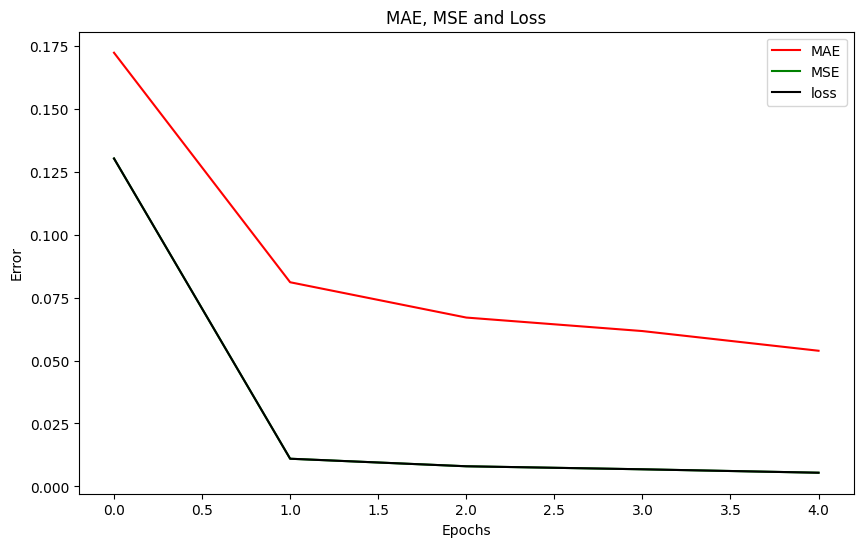

In [60]:
#@title define model parameters
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_3.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop())
# fit
history = model_3.fit(train_data,epochs=5,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(2719, 1) (201, 1)
(2719, 1)


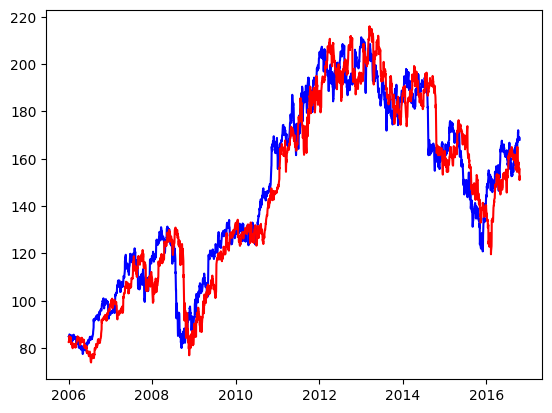

In [61]:
#@title  evaluate for training and test
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=32, shuffle_buffer=0)

train_IBM  = model_3.predict(train_data)
test_IBM  = model_3.predict(test_data)
print(train_IBM.shape, test_IBM.shape)


train_pred = sc.inverse_transform(train_IBM)

time = data_IBM.index.values
print(train_pred.shape)
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], train_pred[:,0],color='blue', label='predicted')
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], set_entrenamiento.High.values[0:train_pred.shape[0]], color='red', label='real')

(201, 1) (251, 1)


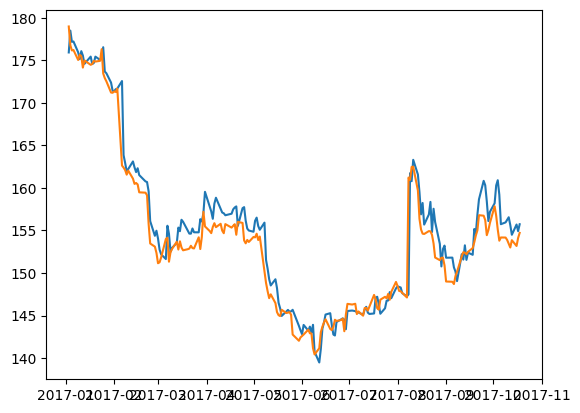

In [62]:
#@title plot the test
pred_test = sc.inverse_transform(test_IBM)
print(pred_test.shape, set_test.shape)
plt.plot(set_test.index.values[0:test_IBM.shape[0]], pred_test)
plt.plot(set_test.index.values[0:test_IBM.shape[0]], set_test[50:])

(201, 1) (251,)


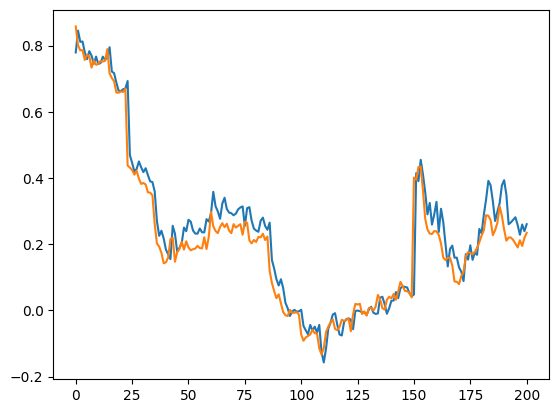

In [63]:
#@title plot the test (raw predictions)
print(test_IBM.shape,  set_test_escalado.shape)
#plt.plot(train_IBM)
#plt.plot(set_entrenamiento_escalado)
plt.plot(test_IBM)
plt.plot(set_test_escalado[50:])

### **Some conclusions**
- RNN are sufficient to follow and forecasting temporal series with marked patterns

- In more complex dataset looks no sufficient to forecast series (short memory)

# References

[1. Forecasting: principles and practique](https://otexts.com/fpp2/)

[2. Sequences, Time Series and Prediction](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/)

[3. RNN in tensorflow](https://www.tensorflow.org/guide/keras/rnn)
